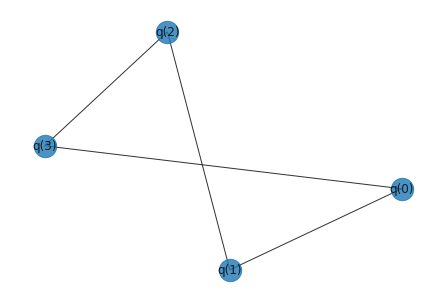

In [11]:
import networkx as nx
from networkx import Graph
from cirq import LineQubit

g = Graph()
nodes = [LineQubit(i) for i in range(4)]
edges = [(nodes[i], nodes[(i+1) % 4]) for i in range(4)]
g.add_nodes_from(nodes)
g.add_edges_from(edges)
nx.draw(g, with_labels=True, alpha=0.8, node_size=500)

In [12]:
from cirq import Rx
from sympy import Symbol

def mixer(g: Graph, beta: Symbol):
    return [ Rx(rads=2*beta)(q) for q in list(g.nodes())]

In [13]:
from openfermion import Rzz

def problem(g: Graph, gamma: Symbol):
    return [ Rzz(rads=2*gamma)(i, j) for i, j in g.edges()]

In [14]:
from cirq import Circuit, H, measure, Moment

beta = Symbol("beta")
gamma = Symbol("gamma")

qaoa_circuit = Circuit(
    H.on_each(*nodes),
    problem(g, gamma),
    Moment(mixer(g, beta)),
    problem(g, gamma),
    Moment(mixer(g, beta)),
    (measure(q) for q in nodes)
)

In [6]:
from cirq.contrib.svg import SVGCircuit

# SVGCircuit(qaoa_circuit)
print(qaoa_circuit)

                            ┌──────────────────────────────┐                                                    ┌──────────────────────────────┐
0: ───H───ZZ─────────────────ZZ──────────────────────────────────────────────────Rx(2*beta)───ZZ─────────────────ZZ──────────────────────────────────────────────────Rx(2*beta)───M───
          │                  │                                                                │                  │
1: ───H───ZZ^(4*gamma/pi)────┼──────────────ZZ───────────────────────────────────Rx(2*beta)───ZZ^(4*gamma/pi)────┼──────────────ZZ───────────────────────────────────Rx(2*beta)───M───
                             │              │                                                                    │              │
2: ───H──────────────────────┼──────────────ZZ^(4*gamma/pi)────ZZ────────────────Rx(2*beta)──────────────────────┼──────────────ZZ^(4*gamma/pi)────ZZ────────────────Rx(2*beta)───M───
                             │                               

In [15]:
import pandas as pd
import numpy as np

def estimate_cost(graph: Graph, samples: pd.DataFrame) -> float:
    """Estimate the cost function of the QAOA on the given graph using the
    provided computational basis bitstrings."""
    cost_value = 0.0

    # Loop over edge pairs and compute contribution.
    for u, v in graph.edges():
        u_samples = samples[str(u)]
        v_samples = samples[str(v)]

        # Determine if it was a +1 or -1 eigenvalue.
        u_signs = (-1) ** u_samples
        v_signs = (-1) ** v_samples
        term_signs = u_signs * v_signs

        # Add scaled term to total cost.
        term_val = np.mean(term_signs)
        cost_value += term_val

    return -cost_value

In [18]:
from cirq import Linspace, Simulator

grid_size = 10

gamma_sweep = Linspace(gamma, 0, np.pi, grid_size)
beta_sweep = Linspace(beta, 0, np.pi, grid_size)
# cartesian product of two sweeps
combinations = gamma_sweep * beta_sweep
sim = Simulator()
samples = sim.run_sweep(
    qaoa_circuit, params=gamma_sweep * beta_sweep, repetitions=20_000
)

exp_values = np.reshape(samples, (-1, grid_size)).tolist()
estimate = np.vectorize(lambda s: estimate_cost(g, s.data))
exp_values = estimate(exp_values)
par_tuples = [tuple(y[1] for y in x) for x in (gamma_sweep * beta_sweep).param_tuples()]
print(par_tuples[:10])
par_values = np.reshape(par_tuples, (-1, grid_size, 2))
print(par_values[:10])
print("test")

[(0.0, 0.0), (0.0, 0.3490658503988659), (0.0, 0.6981317007977318), (0.0, 1.0471975511965976), (0.0, 1.3962634015954636), (0.0, 1.7453292519943295), (0.0, 2.0943951023931953), (0.0, 2.443460952792061), (0.0, 2.792526803190927), (0.0, 3.141592653589793)]
[[[0.         0.        ]
  [0.         0.34906585]
  [0.         0.6981317 ]
  [0.         1.04719755]
  [0.         1.3962634 ]
  [0.         1.74532925]
  [0.         2.0943951 ]
  [0.         2.44346095]
  [0.         2.7925268 ]
  [0.         3.14159265]]

 [[0.34906585 0.        ]
  [0.34906585 0.34906585]
  [0.34906585 0.6981317 ]
  [0.34906585 1.04719755]
  [0.34906585 1.3962634 ]
  [0.34906585 1.74532925]
  [0.34906585 2.0943951 ]
  [0.34906585 2.44346095]
  [0.34906585 2.7925268 ]
  [0.34906585 3.14159265]]

 [[0.6981317  0.        ]
  [0.6981317  0.34906585]
  [0.6981317  0.6981317 ]
  [0.6981317  1.04719755]
  [0.6981317  1.3962634 ]
  [0.6981317  1.74532925]
  [0.6981317  2.0943951 ]
  [0.6981317  2.44346095]
  [0.6981317  2

In [20]:
temp = (gamma_sweep * beta_sweep).param_tuples()
for i, x in enumerate(temp):
    print(x)
    if i == 19:
        break

(('gamma', 0.0), ('beta', 0.0))
(('gamma', 0.0), ('beta', 0.3490658503988659))
(('gamma', 0.0), ('beta', 0.6981317007977318))
(('gamma', 0.0), ('beta', 1.0471975511965976))
(('gamma', 0.0), ('beta', 1.3962634015954636))
(('gamma', 0.0), ('beta', 1.7453292519943295))
(('gamma', 0.0), ('beta', 2.0943951023931953))
(('gamma', 0.0), ('beta', 2.443460952792061))
(('gamma', 0.0), ('beta', 2.792526803190927))
(('gamma', 0.0), ('beta', 3.141592653589793))
(('gamma', 0.3490658503988659), ('beta', 0.0))
(('gamma', 0.3490658503988659), ('beta', 0.3490658503988659))
(('gamma', 0.3490658503988659), ('beta', 0.6981317007977318))
(('gamma', 0.3490658503988659), ('beta', 1.0471975511965976))
(('gamma', 0.3490658503988659), ('beta', 1.3962634015954636))
(('gamma', 0.3490658503988659), ('beta', 1.7453292519943295))
(('gamma', 0.3490658503988659), ('beta', 2.0943951023931953))
(('gamma', 0.3490658503988659), ('beta', 2.443460952792061))
(('gamma', 0.3490658503988659), ('beta', 2.792526803190927))
(('gamm

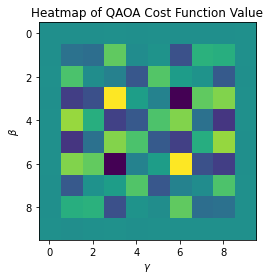

In [9]:
import matplotlib.pyplot as plt

plt.title("Heatmap of QAOA Cost Function Value")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\beta$")
plt.imshow(exp_values)
plt.show()

In [10]:
gamma_value = 2 * np.pi / 5
beta_value = 7 * np.pi / 10

sample_results = sim.sample(
    qaoa_circuit, params={gamma: gamma_value, beta: beta_value}, repetitions=20_000
)
print(f"Gamma = {round(gamma_value, 3)} Beta = {round(beta_value, 3)}")
print(f"Estimated cost: {estimate_cost(g, sample_results)}")

Gamma = 1.257 Beta = 2.199
Estimated cost: 2.7012
